## Set things up

In [1]:
%matplotlib inline
import os
import pandas as pd
import datetime
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

RAW_DATA_SOURCE = "C:/Users/sbranchett/Data/WiFi_data/WiFiAccessPoint.csv"
CLEAN_DATA_SOURCE = "CleanedWiFiAccessPoint.csv"

## Read in data

In [2]:
def load_wifi_data(path):
    """
    Read WiFi clientCount .csv file and sum the clientCounts over building and timestamp, bucketed to 5 minutes
    
    Input: filepath the .csv file
    Output: Dataframe with "building", "time_bucket", "clientCount"
    Columns "building" generated from "locationHierarchy", and "time_bucket" generated from "timestamp"
    """
    all_data = pd.read_csv(path, delimiter=",")
    all_data = all_data.rename(columns=lambda x: x.strip())  # get rid of extra spaces in column names

    sum_clientCounts = all_data["clientCount"].sum()
    
    # extract building from 'locationHierarchy' string and deal with unknown buildings
    all_data["building"] = all_data["locationHierarchy"].str.split(" > ",expand=True)[1]
    all_data["building"] = all_data["building"].fillna("Unknown")

    # convert timestamp from epoch milliseconds to 5 minute buckets (1000 milliseconds * 60 seconds * 5 minutes)
    all_data["time_bucket"] = all_data["timestamp"].apply(lambda d: 300000*int(d/300000))
    
    # keep only the interesting columns
    all_data = all_data[["time_bucket", "building", "clientCount"]]
    
    # sum data over buildings and time buckets
    all_data = all_data.groupby(["time_bucket", "building"]).sum()  # sort on time first so that new data keeps sequence
    
    assert sum_clientCounts == all_data["clientCount"].sum()  # check that no clientCounts went missing

    return all_data

if os.path.isfile(CLEAN_DATA_SOURCE):
    all_data = pd.read_csv(CLEAN_DATA_SOURCE, delimiter=",")
else:
    all_data = load_wifi_data(RAW_DATA_SOURCE)
    all_data.to_csv(CLEAN_DATA_SOURCE)

print(all_data["clientCount"].sum())  # should be 3597531

3597531


In [3]:
all_data.reset_index(inplace=True)  # get rid of multiindex for StratifiedShuffleSplit
print(all_data)

       index    time_bucket               building  clientCount
0          0  1620991800000      03-Science Center           34
1          1  1620991800000             05-TNW-BIO            1
2          2  1620991800000             08-BK-City            2
3          3  1620991800000   19-Studuitzendbureau           13
4          4  1620991800000                20-Aula           32
...      ...            ...                    ...          ...
78161  78161  1621608600000                 64-HSL           10
78162  78162  1621608600000          66-Fellowship          126
78163  78163  1621608600000  Katalyse Labaratorium            8
78164  78164  1621608600000                Unknown           32
78165  78165  1621608600000           VLL-LAB(TNO)           11

[78166 rows x 4 columns]


## Separate Test Set stratified over buildings

In [4]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(all_data, all_data["building"]):
    strat_train_set = all_data.loc[train_index]
    strat_test_set = all_data.loc[test_index]

print(strat_train_set)

       index    time_bucket                           building  clientCount
11688  11688  1621083900000                    37-Sportcentrum           15
61351  61351  1621476000000                         36-ESP-Lab            1
55780  55780  1621431900000                      66-Fellowship          101
26158  26158  1621198200000                          32-OCP-IO           12
34879  34879  1621266900000                             64-HSL           16
...      ...            ...                                ...          ...
50892  50892  1621393500000                            28- WNI            4
33498  33498  1621256100000  36-EWI LB_K t/m 3 & HB_K  t/m 2e           247
4160    4160  1621024500000                      35-Drebbelweg            2
56082  56082  1621434300000                          63-Simona            8
55786  55786  1621432200000                         08-BK-City          670

[62532 rows x 4 columns]


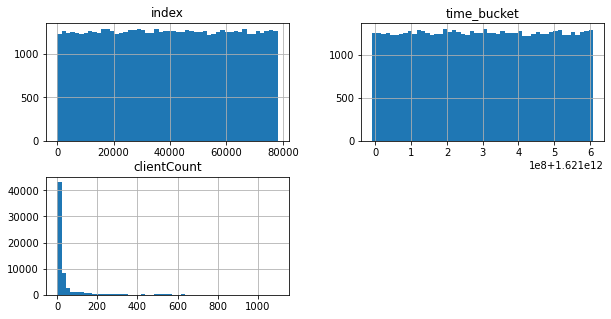

In [5]:
strat_train_set.hist(bins=50, figsize=(10,5))
plt.show()

## Discover data

In [6]:
print(set(strat_train_set["building"].values))

{'19-Studuitzendbureau', '33-Pulse', '05-TNW-BIO', '21-BTUD', '22-TNW-TN', '34-3ME', 'Katalyse Labaratorium', '64-HSL', '63-Simona', '23-CITG', '36-EWI-HB', '28- WNI', '03-Science Center', '32a- Learninglab', '36-ESP-Lab', '31-TBM', '25-GreenVillage', '62-LR', '58-TNW-Zuid', '36-EWI LB_K t/m 3 & HB_K  t/m 2e ', '46-P E lab', 'Unknown', '50-TNW-RID', '35-Drebbelweg', '08-BK-City', '45-LSL', '66-Fellowship', 'VLL-LAB(TNO)', '37-Sportcentrum', '30-IKC_ISD-FMVG', '20-Aula', '38-Cultureel Centrum', '61-Vliegtuighal', '30-O S', '60-LMS', '32-OCP-IO', '43-EGM', '26-Bouwcampus'}


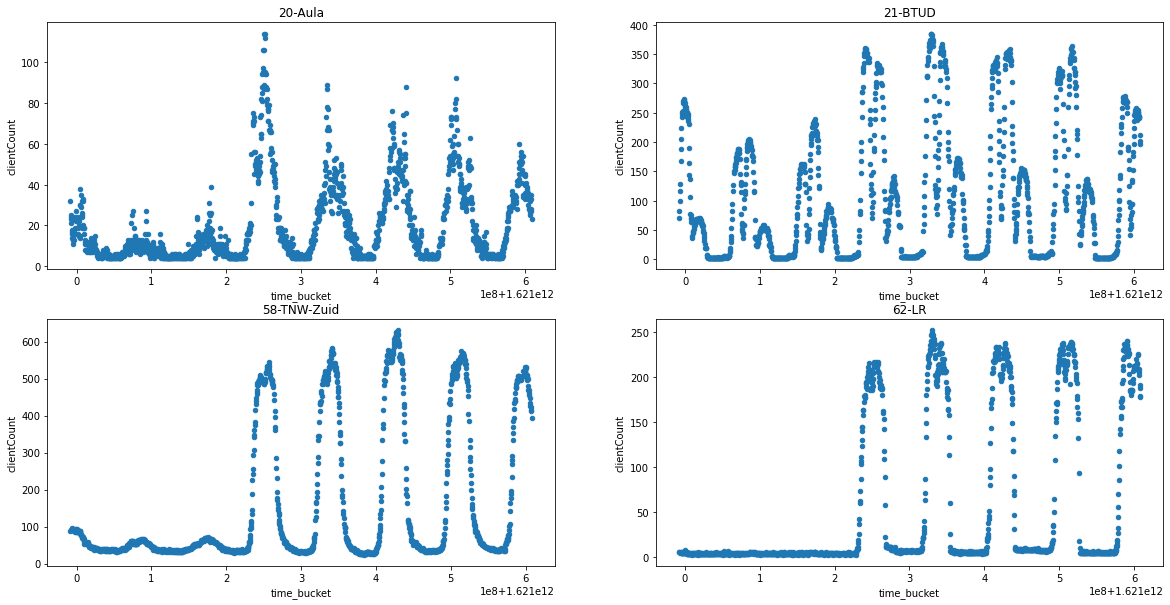

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)

strat_train_set.loc[strat_train_set["building"] == "20-Aula"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[0,0]).set_title("20-Aula")
strat_train_set.loc[strat_train_set["building"] == "21-BTUD"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[0,1]).set_title("21-BTUD")
strat_train_set.loc[strat_train_set["building"] == "58-TNW-Zuid"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[1,0]).set_title("58-TNW-Zuid")
strat_train_set.loc[strat_train_set["building"] == "62-LR"].plot(kind="scatter", x="time_bucket", y="clientCount", figsize=(20,10), ax=axes[1,1]).set_title("62-LR")

plt.show()